In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from agents import OrganicUserEventCounterAgent, organic_user_count_args
from agents import SkylineAgent, skyline_args
from agents import RandomAgent, random_args

from agents import PyTorchMLRAgent, pytorch_mlr_args
from datetime import datetime

In [2]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from agents import OrganicUserEventCounterAgent, organic_user_count_args
from agents import SkylineAgent, skyline_args
from agents import RandomAgent, random_args
from reco_gym import (
    Configuration,
    build_agent_init,
    env_1_args,
    gather_agent_stats,
    plot_agent_stats
)

from agents import PyTorchMLRAgent, pytorch_mlr_args
from datetime import datetime

# General parameters for experiments
RandomSeed = 42
TrainingDataSamples = [1000, 2000, 4000, 6000, 8000, 10000]
TestingDataSamples = 10000
StatEpochs = 5
StatEpochsNewRandomSeed = True

def grid_search_parameter(
        parameter_name, parameter_values,
        agent_name, agent_pytorch_mlr_args,
        env_args, extra_env_args,
        train_samples=5000, valid_samples=10000, valid_runs=5,
):
    ''' Perform a grid search by doing an A/B test with model variants that use different parameter values, log the rsult and return the optimal parameter value '''
    print(f'\tGrid search for {agent_name}')
    grid_search_agent_inits = dict()
    for parameter_value in parameter_values:
        agent_name_with_specified_parameter = f'{agent_name} ({parameter_name} = {parameter_value})'
        grid_search_agent_inits.update(
            build_agent_init(
                agent_name_with_specified_parameter,
                PyTorchMLRAgent,
                {
                    **agent_pytorch_mlr_args,
                    parameter_name: parameter_value
                }
            )
        )

    ### Run A/B test with model variants
    agent_stats = gather_agent_stats(
        env,
        env_args,
        {
            **extra_env_args
        },
        grid_search_agent_inits,
        [train_samples],
        valid_samples,
        valid_runs,
        StatEpochsNewRandomSeed
    )

    # Messy way to get everything into pandas, but it works 
    gg = agent_stats[list(agent_stats.keys())[1]]
    l = []
    for k in list(gg.keys()):
        f = pd.DataFrame(gg[k])
        f['Alg'] = k
        f['Samples'] = agent_stats[list(agent_stats.keys())[0]]
        l.append(f)
    agent_stats_df = pd.concat(l)
    agent_stats_df.columns = [str(c) for c in agent_stats_df.columns]
    values = agent_stats_df['AgentStats.Q0_500'].values
    optimal_parameter_value = parameter_values[np.argmax(values)]
    print(agent_stats_df)
    agent_stats_df.to_csv(f'GS_{agent_name.replace(" ", "_")}_pop.csv', index=False)
    print(f'\t... optimal {parameter_name} = {optimal_parameter_value}!')
    return optimal_parameter_value

num_products=100
print('#' * 48)
print(f'{datetime.now()}\tLogging Popularity with {num_products} products...')
print('#' * 48)

    # Environment parameters
std_env_args = {
    **env_1_args,
    'random_seed': RandomSeed,
    'num_products': num_products,
}
env = gym.make('reco-gym-v1')

# Logging policy
logger = RandomAgent(Configuration({**random_args,**std_env_args}))

std_extra_env_args = {
    'num_products': num_products,
    'number_of_flips': num_products // 2,
    'agent': logger,
}

    ###################################################
    # Grid searches for POEM and Dual Bandit variants #
    ###################################################

################################################
2022-02-27 19:58:33.969036	Logging Popularity with 100 products...
################################################


In [3]:
 # Original POEM
lambdas_poem_no_log = [.0, .05, .1, .25, .5, 1.0, 2.0]
poem_no_log_mlr_args = {
    **pytorch_mlr_args,
    'logIPS': False,    }
optimal_svp_strength_nolog = grid_search_parameter(
    'variance_penalisation_strength', lambdas_poem_no_log,
    'POEM no log', poem_no_log_mlr_args,
    std_env_args, std_extra_env_args,
)

	Grid search for POEM no log
Agent: POEM no log (variance_penalisation_strength = 0.0)
Start: Num of Offline Users: 5000
End: Num of Offline Users: 5000 (572.7384872436523s)
Agent: POEM no log (variance_penalisation_strength = 0.05)
Start: Num of Offline Users: 5000
End: Num of Offline Users: 5000 (554.8458678722382s)
Agent: POEM no log (variance_penalisation_strength = 0.1)
Start: Num of Offline Users: 5000
End: Num of Offline Users: 5000 (597.6089110374451s)
Agent: POEM no log (variance_penalisation_strength = 0.25)
Start: Num of Offline Users: 5000
End: Num of Offline Users: 5000 (610.9581878185272s)
Agent: POEM no log (variance_penalisation_strength = 0.5)
Start: Num of Offline Users: 5000
End: Num of Offline Users: 5000 (580.8711252212524s)
Agent: POEM no log (variance_penalisation_strength = 1.0)
Start: Num of Offline Users: 5000
End: Num of Offline Users: 5000 (571.6062297821045s)
Agent: POEM no log (variance_penalisation_strength = 2.0)
Start: Num of Offline Users: 5000
End: Nu

In [4]:
optimal_svp_strength_nolog

0.05

In [5]:
# Logarithmic POEM
lambdas_poem_log = [0.0, .05, .1, .25, .5, 1.0, 2.0]
poem_log_mlr_args = {
    **pytorch_mlr_args,
    'logIPS': True,
}
optimal_svp_strength_withlog = grid_search_parameter(
    'variance_penalisation_strength', lambdas_poem_log,
    'POEM log', poem_log_mlr_args,
    std_env_args, std_extra_env_args,
)

	Grid search for POEM log
Agent: POEM log (variance_penalisation_strength = 0.0)
Start: Num of Offline Users: 5000
End: Num of Offline Users: 5000 (541.1340079307556s)
Agent: POEM log (variance_penalisation_strength = 0.05)
Start: Num of Offline Users: 5000
End: Num of Offline Users: 5000 (562.2070987224579s)
Agent: POEM log (variance_penalisation_strength = 0.1)
Start: Num of Offline Users: 5000
End: Num of Offline Users: 5000 (548.6256659030914s)
Agent: POEM log (variance_penalisation_strength = 0.25)
Start: Num of Offline Users: 5000
End: Num of Offline Users: 5000 (554.143247127533s)
Agent: POEM log (variance_penalisation_strength = 0.5)
Start: Num of Offline Users: 5000
End: Num of Offline Users: 5000 (543.0115706920624s)
Agent: POEM log (variance_penalisation_strength = 1.0)
Start: Num of Offline Users: 5000
End: Num of Offline Users: 5000 (545.1622097492218s)
Agent: POEM log (variance_penalisation_strength = 2.0)
Start: Num of Offline Users: 5000
End: Num of Offline Users: 5000 

In [6]:
optimal_svp_strength_withlog

1.0

In [7]:
# Dual Bandit
alphas_dual_bandit_no_log = [.0, .80, .85, .90, .925, .95, .975, .99, .999, .9999, 1.0]
dual_bandit_no_log_mlr_args = {
    **pytorch_mlr_args,
    'logIPS': False,
    'll_IPS': False,
}
optimal_ll_strength_nolog = grid_search_parameter(
    'alpha', alphas_dual_bandit_no_log,
    'Dual Bandit no log', dual_bandit_no_log_mlr_args,
    std_env_args, std_extra_env_args,
)

	Grid search for Dual Bandit no log
Agent: Dual Bandit no log (alpha = 0.0)
Start: Num of Offline Users: 5000
End: Num of Offline Users: 5000 (563.2707438468933s)
Agent: Dual Bandit no log (alpha = 0.8)
Start: Num of Offline Users: 5000
End: Num of Offline Users: 5000 (1252.285492658615s)
Agent: Dual Bandit no log (alpha = 0.85)
Start: Num of Offline Users: 5000
End: Num of Offline Users: 5000 (1404.274442434311s)
Agent: Dual Bandit no log (alpha = 0.9)
Start: Num of Offline Users: 5000
End: Num of Offline Users: 5000 (1654.11661195755s)
Agent: Dual Bandit no log (alpha = 0.925)
Start: Num of Offline Users: 5000
End: Num of Offline Users: 5000 (1698.134665966034s)
Agent: Dual Bandit no log (alpha = 0.95)
Start: Num of Offline Users: 5000
End: Num of Offline Users: 5000 (1153.9803512096405s)
Agent: Dual Bandit no log (alpha = 0.975)
Start: Num of Offline Users: 5000
End: Num of Offline Users: 5000 (800.5087244510651s)
Agent: Dual Bandit no log (alpha = 0.99)
Start: Num of Offline Users:

In [8]:
optimal_ll_strength_nolog

0.8

In [9]:
# Logarithmic Dual Bandit
alphas_dual_bandit_log = [.0, .80, .85, .90, .925, .95, .975, .99, .999, .9999, 1.0]
dual_bandit_log_mlr_args = {
    **pytorch_mlr_args,
    'logIPS': True,
    'll_IPS': False,
}
optimal_ll_strength_withlog = grid_search_parameter(
    'alpha', alphas_dual_bandit_log,
    'Dual Bandit log', dual_bandit_log_mlr_args,
    std_env_args, std_extra_env_args,
)

	Grid search for Dual Bandit log
Agent: Dual Bandit log (alpha = 0.0)
Start: Num of Offline Users: 5000
End: Num of Offline Users: 5000 (546.1985521316528s)
Agent: Dual Bandit log (alpha = 0.8)
Start: Num of Offline Users: 5000
End: Num of Offline Users: 5000 (645.0864424705505s)
Agent: Dual Bandit log (alpha = 0.85)
Start: Num of Offline Users: 5000
End: Num of Offline Users: 5000 (621.4026465415955s)
Agent: Dual Bandit log (alpha = 0.9)
Start: Num of Offline Users: 5000
End: Num of Offline Users: 5000 (611.2184844017029s)
Agent: Dual Bandit log (alpha = 0.925)
Start: Num of Offline Users: 5000
End: Num of Offline Users: 5000 (608.4138479232788s)
Agent: Dual Bandit log (alpha = 0.95)
Start: Num of Offline Users: 5000
End: Num of Offline Users: 5000 (599.4198729991913s)
Agent: Dual Bandit log (alpha = 0.975)
Start: Num of Offline Users: 5000
End: Num of Offline Users: 5000 (632.3114178180695s)
Agent: Dual Bandit log (alpha = 0.99)
Start: Num of Offline Users: 5000
End: Num of Offline U

In [10]:
optimal_ll_strength_withlog

1.0

In [3]:
optimal_svp_strength_nolog=0.05
optimal_svp_strength_withlog=1.0
optimal_ll_strength_nolog=0.8
optimal_ll_strength_withlog=1.0

Agent: Logging
Start: Num of Offline Users: 1000
End: Num of Offline Users: 1000 (33.443182706832886s)
Start: Num of Offline Users: 2000
End: Num of Offline Users: 2000 (37.40733337402344s)
Start: Num of Offline Users: 4000
End: Num of Offline Users: 4000 (43.1478157043457s)
Start: Num of Offline Users: 6000
End: Num of Offline Users: 6000 (50.204749584198s)
Start: Num of Offline Users: 8000
End: Num of Offline Users: 8000 (54.664066314697266s)
Start: Num of Offline Users: 10000
End: Num of Offline Users: 10000 (61.46794581413269s)
Agent: Skyline
Start: Num of Offline Users: 1000
End: Num of Offline Users: 1000 (31.929563760757446s)
Start: Num of Offline Users: 2000
End: Num of Offline Users: 2000 (35.3079297542572s)
Start: Num of Offline Users: 4000
End: Num of Offline Users: 4000 (41.59784555435181s)
Start: Num of Offline Users: 6000
End: Num of Offline Users: 6000 (47.22468829154968s)
Start: Num of Offline Users: 8000
End: Num of Offline Users: 8000 (52.78255867958069s)
Start: Num o

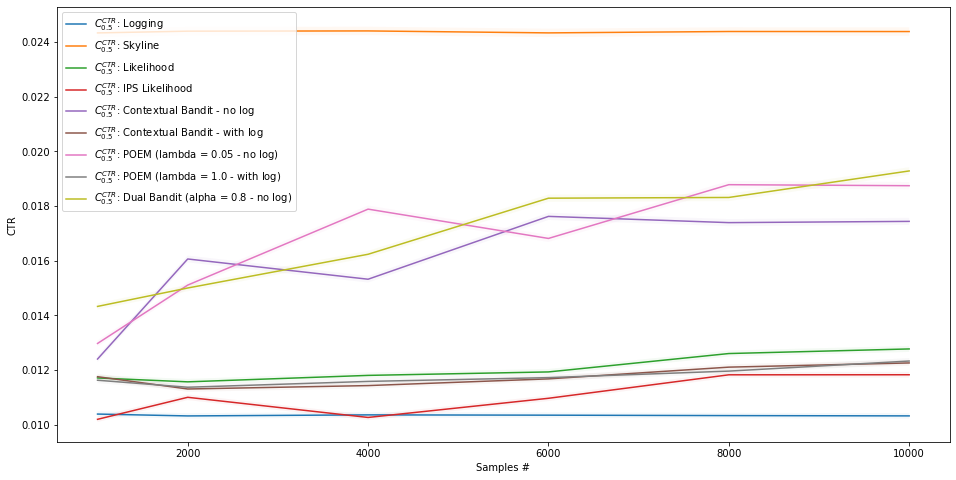

In [4]:
for num_products in [100]:
# Initialisation of different agents
    logging_agent = build_agent_init(
        'Logging',
        RandomAgent,
        {
            **random_args,
            **std_env_args,
        }
    )

    skyline_agent = build_agent_init(
        'Skyline',
        SkylineAgent,
        {
            **skyline_args,
        }
    )

    likelihood_agent = build_agent_init(
        'Likelihood',
        PyTorchMLRAgent,
        {
            **pytorch_mlr_args,
            'll_IPS': False,
            'alpha': 1.0
        }
    )

    ips_likelihood_agent = build_agent_init(
        'IPS Likelihood',
        PyTorchMLRAgent,
        {
            **pytorch_mlr_args,
            'll_IPS': True,
            'alpha': 1.0
        }
    )

    cb_no_log_agent = build_agent_init(
        'Contextual Bandit - no log',
        PyTorchMLRAgent,
        {
            **pytorch_mlr_args,
            'logIPS': False
        }
    )

    cb_log_agent = build_agent_init(
        'Contextual Bandit - with log',
        PyTorchMLRAgent,
        {
            **pytorch_mlr_args,
            'logIPS': True
        }
    )

    poem_no_log_agent = build_agent_init(
        'POEM (lambda = {0} - no log)'.format(optimal_svp_strength_nolog),
        PyTorchMLRAgent,
        {
            **pytorch_mlr_args,
            'logIPS': False,
            'variance_penalisation_strength': optimal_svp_strength_nolog
        }
    )

    poem_log_agent = build_agent_init(
        'POEM (lambda = {0} - with log)'.format(optimal_svp_strength_withlog),
        PyTorchMLRAgent,
        {
            **pytorch_mlr_args,
            'logIPS': True,
            'variance_penalisation_strength': optimal_svp_strength_withlog
        }
    )

    dual_bandit_no_log_agent = build_agent_init(
        'Dual Bandit (alpha = {0} - no log)'.format(optimal_ll_strength_nolog),
        PyTorchMLRAgent,
        {
            **pytorch_mlr_args,
            'logIPS': False,
            'll_IPS': False,
            'alpha': optimal_ll_strength_nolog
        }
    )

    dual_bandit_log_agent = build_agent_init(
        'Dual Bandit (alpha = {0} - with log)'.format(optimal_ll_strength_withlog),
        PyTorchMLRAgent,
        {
            **pytorch_mlr_args,
            'logIPS': True,
            'll_IPS': False,
            'alpha': optimal_ll_strength_withlog
        }
    )

    agent_inits = {
        **logging_agent,
        **skyline_agent,
        **likelihood_agent,
        **ips_likelihood_agent,
        **cb_no_log_agent,
        **cb_log_agent
    }

    if optimal_svp_strength_nolog != 0:
        agent_inits.update(poem_no_log_agent)

    if optimal_svp_strength_withlog != 0:
        agent_inits.update(poem_log_agent)

    if optimal_ll_strength_nolog != 0 and optimal_ll_strength_nolog != 1:
        agent_inits.update(dual_bandit_no_log_agent)

    if optimal_ll_strength_withlog != 0 and optimal_ll_strength_withlog != 1:
        agent_inits.update(dual_bandit_log_agent)

    # Gathering performance of agents for the logging policy: uniform.
    agent_stats01 = gather_agent_stats(
        env,
        std_env_args,
        {
            'num_products': num_products,
            'number_of_flips': num_products // 2,
            'agent': logger
        },
        agent_inits,
        TrainingDataSamples,
        TestingDataSamples,
        StatEpochs,
        StatEpochsNewRandomSeed
    )

    plot_agent_stats(agent_stats01, figname='performance_comparison_{0}_products_uniform.png'.format(num_products))

    def tocsv(stats, file_name):
        import pandas as pd
        gg = stats[list(stats.keys())[1]]

        l = []
        for k in list(gg.keys()):
            f = pd.DataFrame(gg[k])
            f['Alg'] = k.replace('aa', 'a').replace('bb', 'b')
            f['Samples'] = stats[list(stats.keys())[0]]
            l.append(f)
        pd.concat(l).to_csv(file_name)

    tocsv(agent_stats01, 'performance_comparison_{0}_products_uniform.csv'.format(num_products))
